# Simplest Possible Diffusion - No Time Embedding!

Let's strip it down to the absolute basics:
- ✅ Simple Conv autoencoder (like VAE encoder/decoder)
- ✅ NO time embedding - same network for all timesteps
- ✅ Just learn: noisy image → predicted noise

**Why this works:**
The network can still implicitly learn different noise levels from the data distribution.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from realistica import NoiseScheduler, TinyConvDenoiser

## Config

In [25]:
# Training control
LOAD_MODEL = True  # Set to False to train from scratch

device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
print(f"Device: {device}")

config = {
    'batch_size': 128,
    'num_epochs': 20,
    'lr': 1e-3,
    'num_timesteps': 1000,
    'checkpoint_path': 'outputs/mnist_conv_simple/checkpoint.pt',
}

os.makedirs('outputs/mnist_conv_simple/samples', exist_ok=True)
os.makedirs('outputs/mnist_conv_simple', exist_ok=True)

Device: mps


## Load Data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

print(f"Dataset: {len(train_dataset)} images")

Dataset: 60000 images


## Model - Super Simple!

In [ ]:
# Noise scheduler
noise_scheduler = NoiseScheduler(
    num_timesteps=config['num_timesteps'],
    beta_start=0.0001,
    beta_end=0.02,
    schedule_type='linear',
    device=device
)

# Tiny conv model - NO time embedding!
model = TinyConvDenoiser().to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {num_params:,}")

# Load checkpoint if exists and LOAD_MODEL is True
if LOAD_MODEL and os.path.exists(config['checkpoint_path']):
    print(f"Loading model from {config['checkpoint_path']}")
    model.load_state_dict(torch.load(config['checkpoint_path'], map_location=device))
    print("Model loaded!")
else:
    print("Training from scratch")

print(f"\nArchitecture:")
print(model)

## Training - Dead Simple

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.MSELoss()

losses = []

for epoch in range(config['num_epochs']):
    model.train()
    epoch_loss = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")
    for images, _ in pbar:
        images = images.to(device)
        batch_size = images.shape[0]
        
        # Random timesteps
        t = noise_scheduler.sample_timesteps(batch_size)
        
        # Add noise
        noisy_images, noise = noise_scheduler.add_noise(images, t)
        
        # Predict noise (NO time input!)
        pred_noise = model(noisy_images)
        
        # Loss
        loss = criterion(pred_noise, noise)
        
        # Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.6f}")

# Save model
print(f"\nSaving model to {config['checkpoint_path']}")
torch.save(model.state_dict(), config['checkpoint_path'])
print("Done!")

## Sample

Sampling: 1000it [00:03, 297.78it/s]


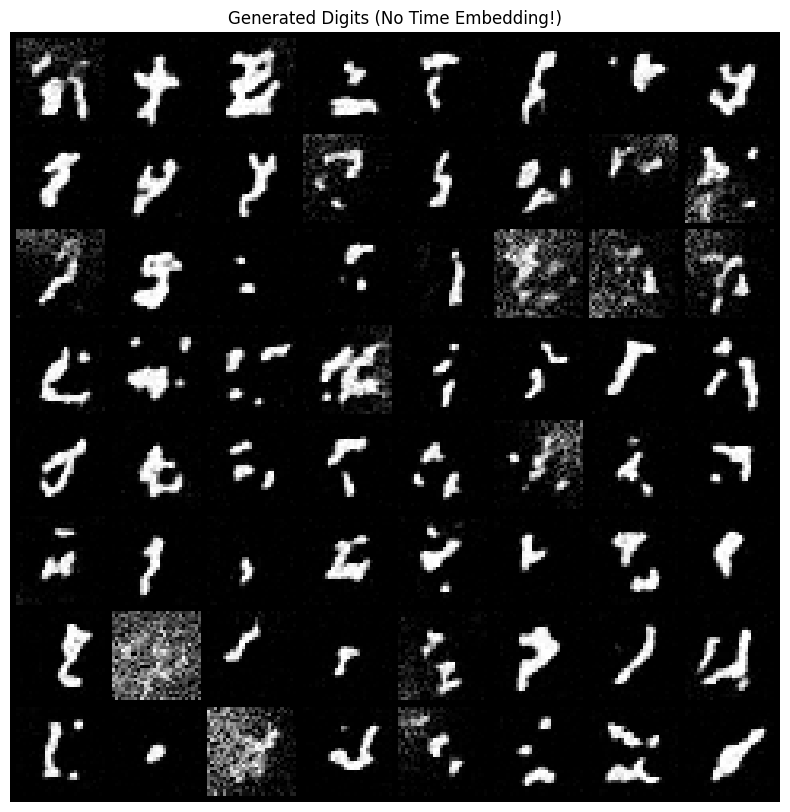

In [23]:
@torch.no_grad()
def sample(num_samples=64):
    model.eval()
    
    # Start from noise
    x = torch.randn(num_samples, 1, 28, 28, device=device)
    
    # Denoise
    for t in tqdm(reversed(range(config['num_timesteps'])), desc='Sampling'):
        t_batch = torch.tensor([t] * num_samples, device=device)
        
        # Predict noise (model ignores t)
        pred_noise = model(x)
        
        alpha = noise_scheduler.alphas[t]
        alpha_cumprod = noise_scheduler.alphas_cumprod[t]
        beta = noise_scheduler.betas[t]
        
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        
        # DDPM step
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod)) * pred_noise)
        x = x + torch.sqrt(beta) * noise
    
    return x

# Generate
samples = sample(64)

# Show
grid = make_grid(samples, nrow=8, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title('Generated Digits (No Time Embedding!)')
plt.savefig('outputs/mnist_conv_simple/samples/generated.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualize Denoising

100%|██████████| 1000/1000 [00:00<00:00, 1434.23it/s]


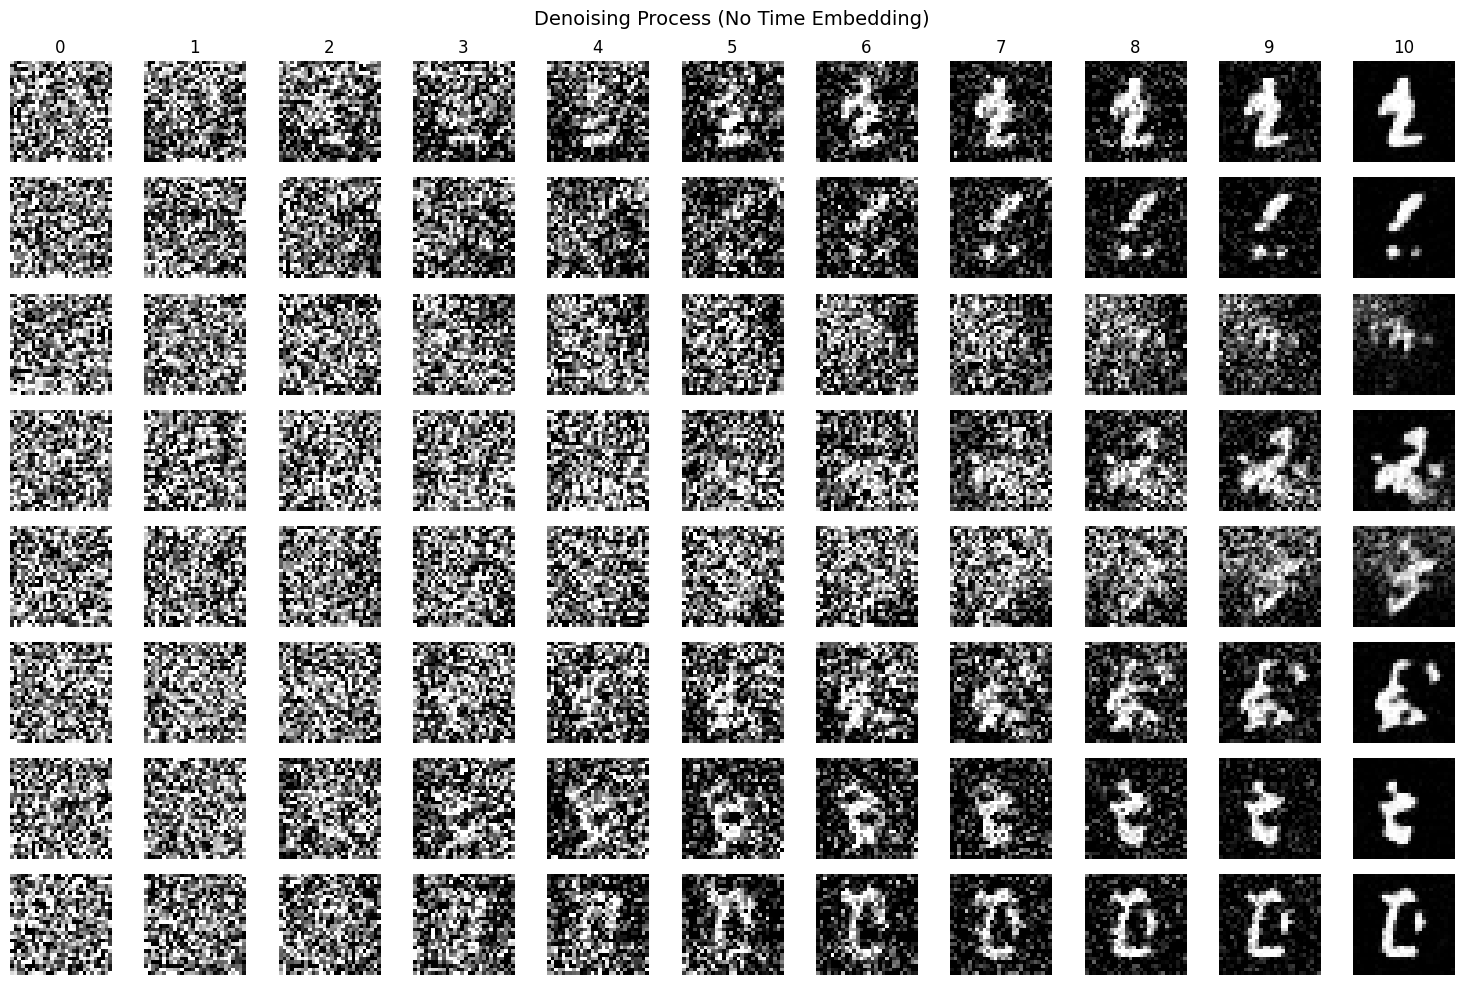

In [22]:
@torch.no_grad()
def sample_steps(num_samples=8, steps_to_show=10):
    model.eval()
    x = torch.randn(num_samples, 1, 28, 28, device=device)
    
    timesteps = list(reversed(range(config['num_timesteps'])))
    interval = len(timesteps) // steps_to_show
    saved = []
    
    for i, t in enumerate(tqdm(timesteps)):
        if i % interval == 0 or i == len(timesteps) - 1:
            saved.append(x.cpu().clone())
        
        pred_noise = model(x)
        
        alpha = noise_scheduler.alphas[t]
        alpha_cumprod = noise_scheduler.alphas_cumprod[t]
        beta = noise_scheduler.betas[t]
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod)) * pred_noise)
        x = x + torch.sqrt(beta) * noise
    
    return saved

steps = sample_steps(8, 10)

# Plot
fig, axes = plt.subplots(8, len(steps), figsize=(15, 10))
for i in range(8):
    for j, imgs in enumerate(steps):
        axes[i, j].imshow(imgs[i, 0].numpy(), cmap='gray', vmin=-1, vmax=1)
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(f'{j}')

plt.suptitle('Denoising Process (No Time Embedding)', fontsize=14)
plt.tight_layout()
plt.show()

## Does it work?

**Expected:**
- Model has only ~50K parameters
- No time conditioning at all
- Should still produce digit-like shapes
- Quality won't be amazing, but proves the concept

**If you see digits:** ✅ Your diffusion setup works!

**If you see maze patterns:** Try:
1. More epochs (30-50)
2. Lower learning rate (1e-4)
3. Check data normalization is [-1, 1]

**Next step:** Add time embedding for better quality